In [ ]:
# Import lib
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import os
import zipfile
from scipy.spatial.distance import euclidean
from google.colab import files

In [ ]:
def find_masks(image, k_head, sh_from, sh_to):
  """
  Identifies and creates masks for specific depth values in an input depth image.

  Parameters:
  - image: Input image with depth values.
  - k_head: Number of top depth values to include in the mask.
  - sh_from: Start index for the range of depth values to include in a separate mask.
  - sh_to: End index (exclusive) for the range of depth values to include in a separate mask.

  Returns:
  - barycentre: Coordinates of the barycentre (mean) of pixels with the lowest depth value.
  - h_mask: Boolean mask for the top k_head depth values.
  - sh_mask: Boolean mask for depth values within the specified range [sh_from, sh_to).
  """
  depth_non_zero = image[image != 0]

  lower_value = np.unique(np.sort(depth_non_zero))[0]
  top_head_mask = np.zeros_like(image, dtype=bool)

  h_values = np.unique(np.sort(depth_non_zero))[:k_head]
  h_mask = np.zeros_like(image, dtype=bool)

  sh_values = np.unique(np.sort(depth_non_zero))[sh_from:sh_to]
  sh_mask = np.zeros_like(image, dtype=bool)

  top_head_mask = top_head_mask | (image == lower_value)
  indices = np.transpose(np.nonzero(top_head_mask))
  barycentre = int(np.mean(indices[:, 1])), int(np.mean(indices[:, 0]))

  for valeur in h_values:
    h_mask = h_mask | (image == valeur)

  for valeur in sh_values:
    sh_mask = sh_mask | (image == valeur)

  return barycentre, h_mask, sh_mask

In [ ]:
# Fonction qui permet de retourner tous les points pour le graph

def find_extreme_points(mask):
    """
    Finds the extreme points (top, bottom, left, and right) of a boolean mask.

    Parameters:
    - mask: Boolean mask.

    Returns:
    - top_point: Coordinates of the topmost point in the mask.
    - bottom_point: Coordinates of the bottommost point in the mask.
    - left_point: Coordinates of the leftmost point in the mask.
    - right_point: Coordinates of the rightmost point in the mask.
    """
    indices = np.argwhere(mask)
    top_point = tuple(indices[indices[:, 0].argmin()][::-1])
    bottom_point = tuple(indices[indices[:, 0].argmax()][::-1])
    left_point = tuple(indices[indices[:, 1].argmin()][::-1])
    right_point = tuple(indices[indices[:, 1].argmax()][::-1])

    return top_point, bottom_point, left_point, right_point

In [ ]:
# Fonction qui permet de calculer l'angle de rotation de l'image en fonction du masque des épaules

def find_angle(mask_shoulders):
  """
  Finds the angle of rotation based on the extreme points of a shoulders mask.

  Parameters:
  - mask_shoulders: Boolean mask representing the shoulders.

  Returns:
  - angle: Angle of rotation in degrees.
  """
  indices = np.argwhere(mask_shoulders)
  top_point = tuple(indices[indices[:, 0].argmin()][::-1])
  bottom_point = tuple(indices[indices[:, 0].argmax()][::-1])
  left_point = tuple(indices[indices[:, 1].argmin()][::-1])
  right_point = tuple(indices[indices[:, 1].argmax()][::-1])

  # Calculer les distances entre chaque paire de points
  distance_top_bottom = euclidean(top_point, bottom_point)
  distance_left_right = euclidean(left_point, right_point)

  # Sélectionner les points en fonction de la distance
  if distance_top_bottom > distance_left_right:
    point1, point2 = top_point, bottom_point
  else:
    point1, point2 = left_point, right_point

  # Calcul de l'angle de rotation
  x1, y1 = point1
  x2, y2 = point2
  angle = np.degrees(np.arctan2(y2 - y1, x2 - x1))

  return 90 - angle

In [ ]:
# Fonction pour rotate une image en fonction d'une image et d'un angle
# But : mettre la ligne des épaules perpendiculaire à l'axe des abscisses

def rotate_image_by_angle(img, angle):
  height, width = img.shape[:2]
  center = (width // 2, height // 2)

  # Création de la matrice de rotation
  rotation_matrix = cv2.getRotationMatrix2D(center, -angle, 1.0)
  rotated_image = cv2.warpAffine(img, rotation_matrix, (width, height), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=0)

  return rotated_image

In [ ]:
# Fonction pour rotate un masque en fonction d'unn masque et d'un angle
# But : mettre la ligne des épaules perpendiculaire à l'axe des abscisses

def rotate_mask_by_angle(mask, angle):
    mask = mask.astype(np.uint8)

    height, width = mask.shape[:2]
    center = (width // 2, height // 2)

    rotated_mask = np.zeros_like(mask)

    rotation_matrix = cv2.getRotationMatrix2D(center, -angle, 1.0)
    rotated_mask = cv2.warpAffine(mask, rotation_matrix, (mask.shape[1], mask.shape[0]), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=0)

    return rotated_mask

In [ ]:
# Fonction pour calculer la matrice de distances

def distance_matrix(points):
    points = np.array(points)
    num_points = len(points)
    dist_matrix = np.zeros((num_points, num_points))

    for i in range(num_points):
        for j in range(i+1, num_points):
            distance = np.linalg.norm(points[i] - points[j])
            norm_distance = 1 - distance / 150.0
            dist_matrix[i, j] = norm_distance
            dist_matrix[j, i] = norm_distance

    np.fill_diagonal(dist_matrix, 1.0)

    return dist_matrix

In [ ]:
def get_list_depth_values(depth_image, point_list):
  """
  Extracts depth values from a depth image at specified coordinates.

  Parameters:
  - depth_image: 2D array representing a depth image.
  - point_list: List of (x, y) coordinates.

  Returns:
  - list_depth_values: List of depth values corresponding to the coordinates.
  """
  list_depth_values = []

  for coord in point_list:
    x, y = coord
    if 0 <= x < len(depth_image) and 0 <= y < len(depth_image[0]):
      list_depth_values.append((depth_image[x][y] - 1000) / (3500 - 1000))
    else:
      list_depth_values.append(None)

  return list_depth_values

In [ ]:
# Fonction pour créer le graph

def create_graph_from_points(distance_matrix, points_list):
  graph = nx.Graph()

  for i, coords in enumerate(points_list):
    graph.add_node(i, pos=coords)

  num_points = len(points_list)
  for i in range(num_points):
    for j in range(i+1, num_points):
      graph.add_edge(i, j, weight=distance_matrix[i, j])

  return graph

In [ ]:
def create_graph_from_points_with_depth(distance_matrix, points_list, depth_values):
    """
    Creates a graph from a list of points with associated depth values and a distance matrix.

    Parameters:
    - distance_matrix: 2D array representing the pairwise distances between points.
    - points_list: List of coordinates for each point.
    - depth_values: List of depth values associated with each point.

    Returns:
    - graph: NetworkX Graph object with nodes representing points and edges representing distances.
    """
    graph = nx.Graph()

    for i, coords in enumerate(points_list):
        graph.add_node(i, pos=coords, depth=depth_values[i])

    num_points = len(points_list)
    for i in range(num_points):
        for j in range(i + 1, num_points):
            graph.add_edge(i, j, weight=distance_matrix[i, j]*5)

    return graph

In [ ]:
def final_display_from_id(ids, wanted_id):
  if ids == wanted_id:
    plt.subplot(1, 2, 1)
    plt.title("Masque tête")
    plt.imshow(rotated_mask_head, cmap='gray')
    plt.subplot(1, 2, 2)
    plt.title("Masque épaules")
    plt.imshow(rotated_mask_shoulders, cmap='gray')
    plt.show()

    plt.subplot(1, 2, 1)
    plt.title("Masque avant rotation")
    plt.imshow(mask_head, cmap='gray')
    plt.subplot(1, 2, 2)
    plt.title("Masque après rotation")
    plt.imshow(rotated_mask_head, cmap='gray')
    plt.show()

    plt.subplot(1, 2, 1)
    plt.title("Image avant rotation")
    plt.imshow(depth_image, cmap='gray')
    plt.subplot(1, 2, 2)
    plt.title("Image après rotation")
    plt.imshow(rotated_depth_image, cmap='gray')
    plt.show()

    # Dessin points
    plt.imshow(rotated_depth_image, cmap='gray')
    plt.title('Rotated Image with points')

    plt.scatter(*top_shoulders, c='red', marker='o')
    plt.scatter(*bottom_shoulders, c='red', marker='o')

    plt.scatter(*sommet_head, c='yellow', marker='o')
    plt.scatter(*top_head, c='blue', marker='o')
    plt.scatter(*bottom_head, c='blue', marker='o')
    plt.scatter(*left_head, c='blue', marker='o')
    plt.scatter(*right_head, c='blue', marker='o')
    plt.show()

    # Dessin graph
    pos = nx.get_node_attributes(graph, 'pos')
    nx.draw(graph, pos, with_labels=True, font_weight='bold', width=list(nx.get_edge_attributes(graph, 'weight').values()), edge_color='skyblue', node_size=100, node_color='coral', font_color='white', ax=plt.gca())

    plt.imshow(rotated_depth_image, cmap='gray')
    plt.show()

In [ ]:
uploaded = files.upload()

for zip_filename in uploaded.keys():
    with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
        zip_ref.extractall()

extracted_folder = zip_filename.split('.')[0]
fold_images = "fold_images"
os.rename(zip_filename.split('.')[0], fold_images)

Saving nimages_test.zip to nimages_test.zip


[0.772, 0.8832, 0.2404, 0.2676, 0.2496, 0.3264, 0.3572]
[0.4164, 0.8664, 0.2528, 0.276, 0.2632, 0.8716, 0.8712]


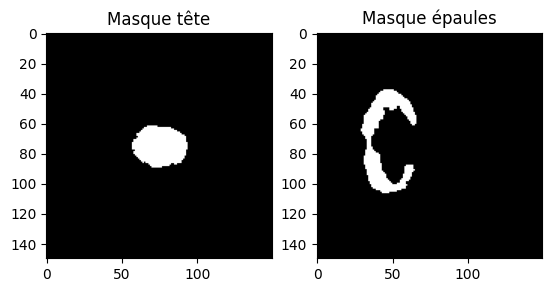

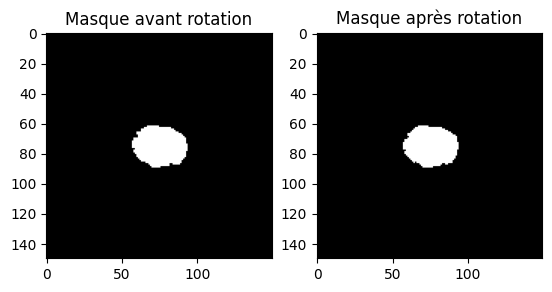

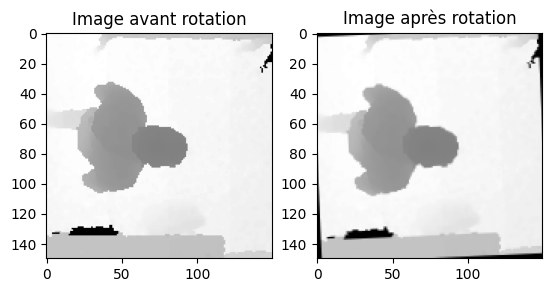

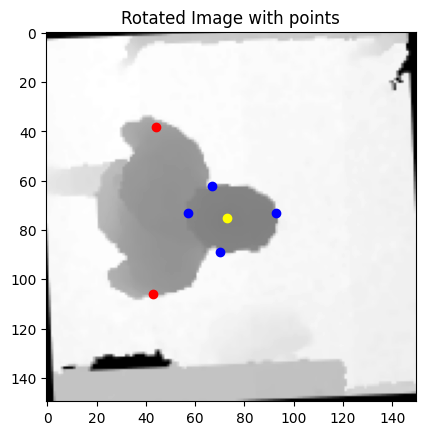

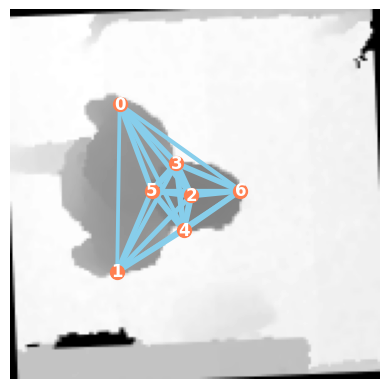

[0.7936, 0.582, 0.2436, 0.25, 0.2584, 0.3264, 0.332]
[0.8368, 0.8596, 0.2464, 0.3292, 0.2528, 0.262, 0.3412]
[0.4184, 0.8596, 0.2528, 0.2776, 0.2588, 0.8664, 0.878]
[0.6248, 0.8596, 0.2588, 0.2924, 0.268, 0.8712, 0.8712]
[0.4112, 0.8264, 0.2464, 0.272, 0.2476, 0.848, 0.8496]
[0.812, 0.6524, 0.2388, 0.2556, 0.2512, 0.3384, 0.3412]
[0.848, 0.8596, 0.2436, 0.3292, 0.2556, 0.2588, 0.3412]
[0.3632, 0.848, 0.2436, 0.2892, 0.25, 0.8596, 0.8512]
[0.8216, 0.7988, 0.2404, 0.3332, 0.2536, 0.2588, 0.3412]
[0.848, 0.8832, 0.2444, 0.3216, 0.27, 0.2576, 0.3496]
[0.856, 0.8832, 0.2436, 0.3252, 0.2652, 0.2548, 0.3412]
[0.388, 0.834, 0.2436, 0.2784, 0.252, 0.8484, 0.8592]
[0.848, 0.8832, 0.2436, 0.3292, 0.2436, 0.2556, 0.3412]
[0.8384, 0.8712, 0.2468, 0.3292, 0.2528, 0.2924, 0.3492]
[0.7936, 0.5844, 0.2436, 0.2464, 0.2548, 0.3312, 0.3328]
[0.8232, 0.6836, 0.2436, 0.3324, 0.2528, 0.2556, 0.3392]
[0.8452, 0.8832, 0.2436, 0.3252, 0.2568, 0.2652, 0.3412]
[0.852, 0.8832, 0.246, 0.3252, 0.2464, 0.2556, 0.3412

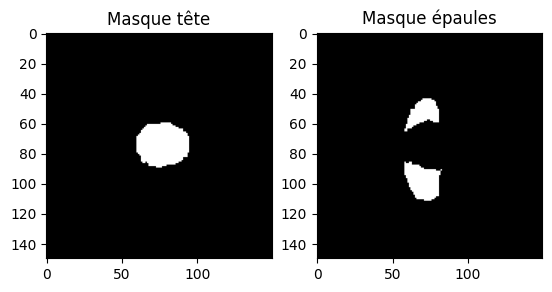

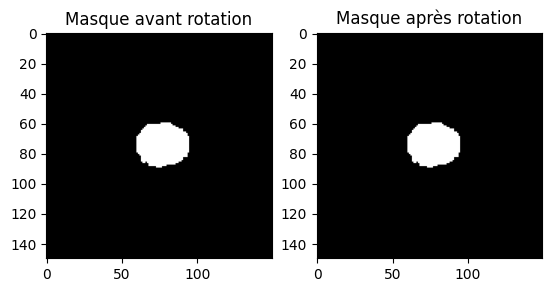

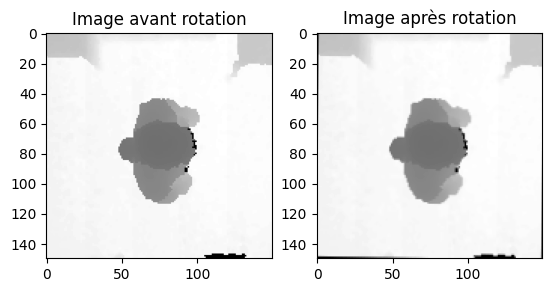

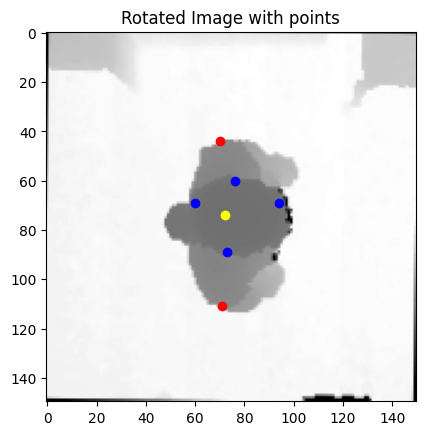

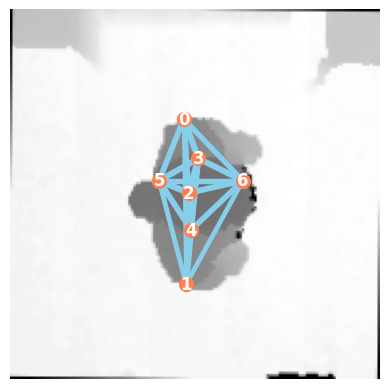

[0.848, 0.87, 0.166, 0.1808, 0.174, 0.1916, 0.2752]
[0.852, 0.8584, 0.164, 0.1764, 0.1736, 0.2512, 0.2748]
[0.1992, 0.4692, 0.164, 0.2012, 0.1756, 0.2856, 0.2748]
[0.8712, 0.8832, 0.164, 0.1856, 0.1756, 0.188, 0.2684]
[0.8596, 0.8016, 0.162, 0.1788, 0.1756, 0.2732, 0.272]
[0.804, 0.3924, 0.1856, 0.188, 0.2012, 0.2116, 0.2144]
[0.8248, 0.4072, 0.1808, 0.1832, 0.196, 0.286, 0.2536]
[0.8476, 0.4964, 0.1664, 0.1812, 0.18, 0.2832, 0.272]
[0.3292, 0.8468, 0.188, 0.2116, 0.1856, 0.1992, 0.8596]
[0.8368, 0.4348, 0.1732, 0.1832, 0.1888, 0.4708, 0.2796]
[0.8596, 0.8832, 0.164, 0.1976, 0.1776, 0.1852, 0.282]
[0.8712, 0.8832, 0.164, 0.1932, 0.178, 0.1832, 0.2752]
[0.2924, 0.8148, 0.1756, 0.1972, 0.1732, 0.1792, 0.848]
[0.854, 0.8712, 0.164, 0.188, 0.1756, 0.2596, 0.272]
[0.3176, 0.8256, 0.188, 0.2036, 0.1732, 0.1908, 0.8596]
[0.8596, 0.8832, 0.1616, 0.2092, 0.1708, 0.1924, 0.2684]
[0.8548, 0.8692, 0.1656, 0.1976, 0.1736, 0.2784, 0.2752]
[0.8508, 0.8632, 0.166, 0.1824, 0.1744, 0.216, 0.2732]
[0.836

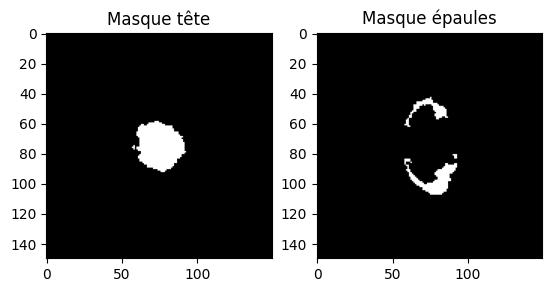

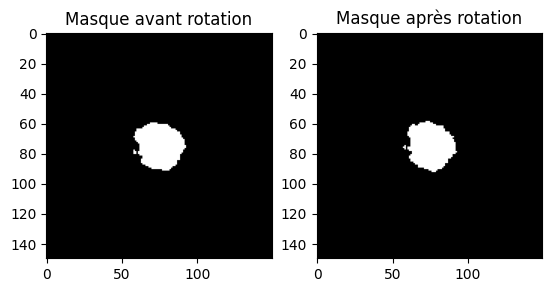

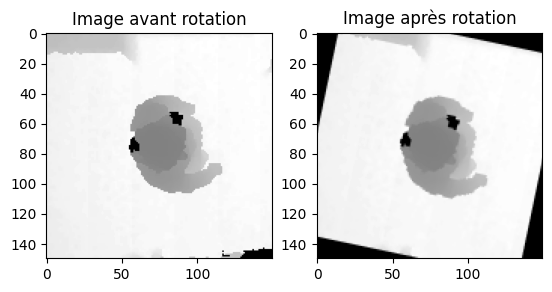

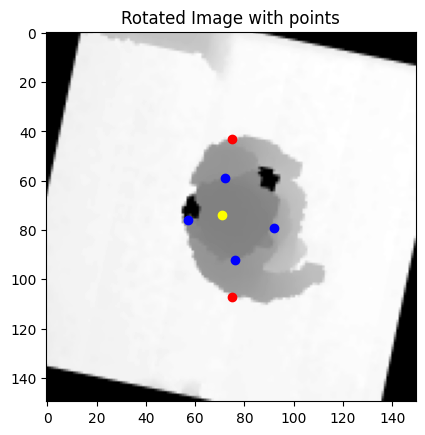

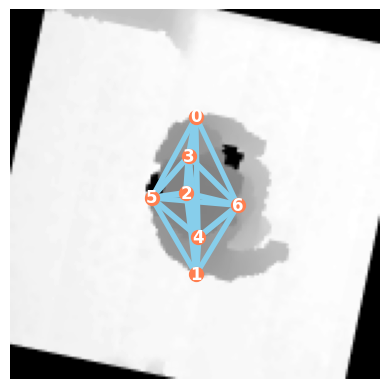

[0.8612, 0.8624, 0.2436, 0.2668, 0.3196, 0.3452, 0.3532]
[0.848, 0.8712, 0.2464, 0.262, 0.544, 0.3464, 0.3644]
[0.8596, 0.8712, 0.2464, -0.4, 0.4464, 0.3584, 0.2728]
[0.8148, 0.546, 0.2556, 0.2528, 0.402, 0.3532, 0.282]
[0.8596, 0.8808, 0.2464, -0.4, 0.2736, 0.3496, 0.348]
[0.848, 0.58, 0.2672, 0.2688, 0.342, 0.3616, 0.3616]
[0.8596, 0.8768, 0.246, 0.2776, 0.2684, 0.3396, 0.308]
[0.8596, 0.8832, 0.2528, 0.3072, 0.2652, 0.2772, 0.3536]
[0.3836, 0.8296, 0.2744, 0.3028, 0.2528, 0.2676, 0.4848]
[0.8596, 0.8832, 0.2496, 0.2712, 0.2648, 0.346, 0.3556]
[0.8596, 0.8824, 0.2528, 0.2684, 0.2652, 0.312, 0.3532]
[0.8472, 0.8, 0.262, 0.2708, 0.4072, 0.3616, 0.3004]
[0.854, 0.8708, 0.2436, 0.2668, 0.4276, 0.3452, 0.2708]
[0.8596, 0.8832, 0.2556, 0.3008, 0.2648, 0.2804, 0.358]
[0.8524, 0.8832, 0.2556, 0.304, 0.2656, 0.2744, 0.5432]
[0.8632, 0.8832, 0.2528, 0.2024, 0.264, 0.3456, 0.3512]
[0.8712, 0.8712, 0.2464, -0.2344, 0.28, 0.3544, 0.2912]
[0.848, 0.8596, 0.2556, 0.2696, 0.2904, 0.3576, 0.2952]
[0.

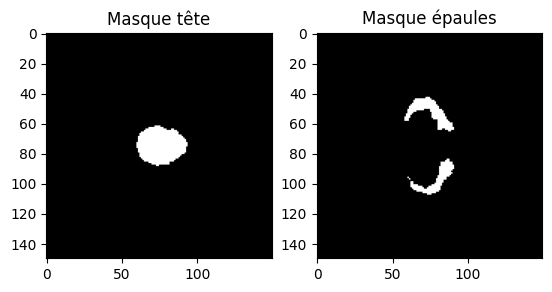

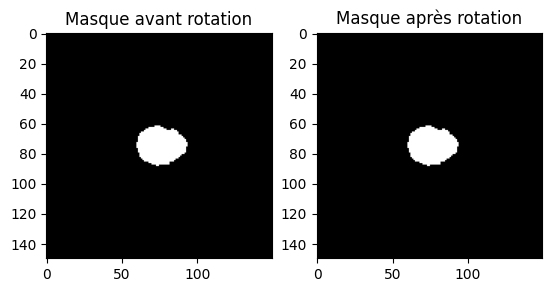

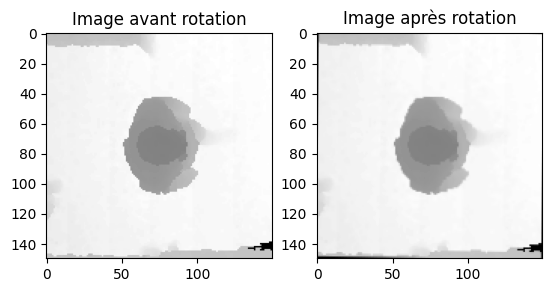

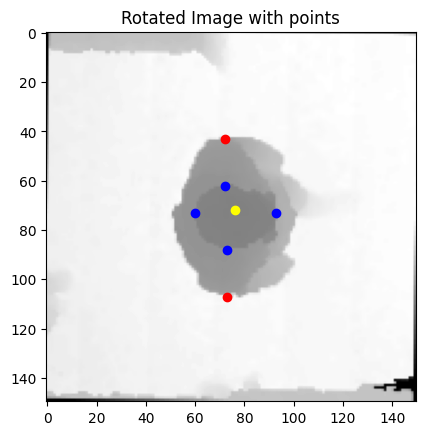

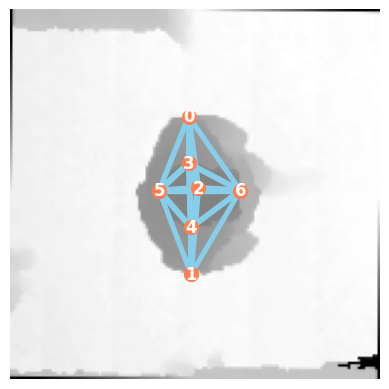

[0.804, 0.512, 0.2648, 0.262, 0.326, 0.3572, 0.3512]
[0.8476, 0.8596, 0.256, 0.2936, 0.2684, 0.3576, 0.3576]
[0.8596, 0.8832, 0.2564, 0.272, 0.256, 0.3576, 0.3412]
[0.8596, 0.8832, 0.2496, 0.3488, 0.274, 0.354, 0.3412]
[0.414, 0.7936, 0.2536, 0.2744, 0.2528, 0.8368, 0.848]
[0.8256, 0.5836, 0.2572, 0.2588, 0.284, 0.3452, 0.3548]
[0.8596, 0.8712, 0.2536, 0.2692, 0.256, 0.3532, 0.3452]
[0.8664, 0.8596, 0.2588, 0.2708, 0.2652, 0.3552, 0.3512]
[0.8268, 0.5204, 0.2496, 0.2588, 0.2744, 0.3452, 0.3492]
[0.8596, 0.8832, 0.2496, 0.8596, 0.2532, 0.3504, 0.3452]
[0.8616, 0.8712, 0.2528, 0.2684, 0.2588, 0.3576, 0.3472]
[0.804, 0.5092, 0.2652, 0.2632, 0.3056, 0.3544, 0.2708]
[0.848, 0.854, 0.2556, 0.3492, 0.256, 0.3524, 0.3492]
[0.3972, 0.8256, 0.2528, 0.282, 0.2588, 0.8464, 0.8368]
[0.848, 0.8832, 0.2528, 0.314, 0.2588, 0.3532, 0.3412]
[0.3904, 0.7936, 0.2588, 0.272, 0.2528, 0.8368, 0.8368]
[0.864, 0.8832, 0.2476, 0.2684, 0.2684, 0.3576, 0.3392]
[0.8368, 0.8072, 0.2556, 0.262, 0.2684, 0.3452, 0.357

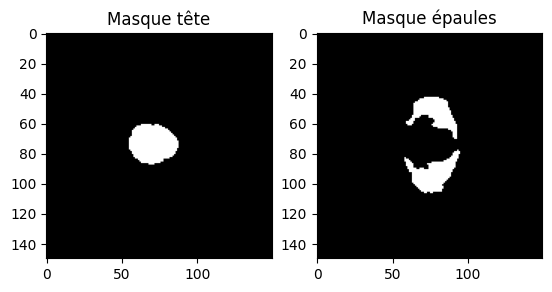

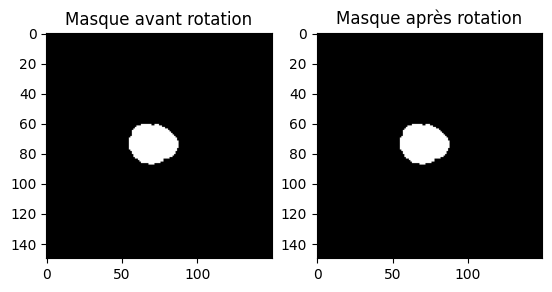

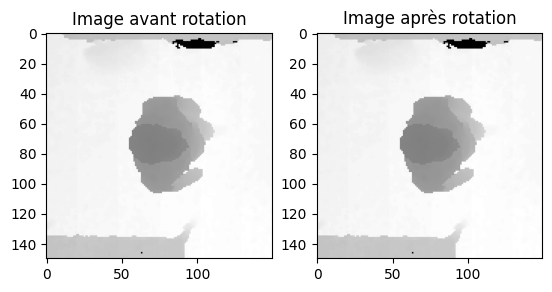

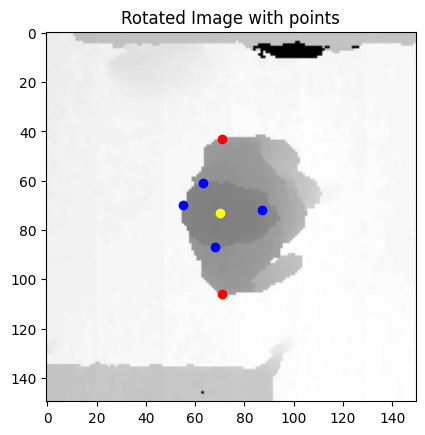

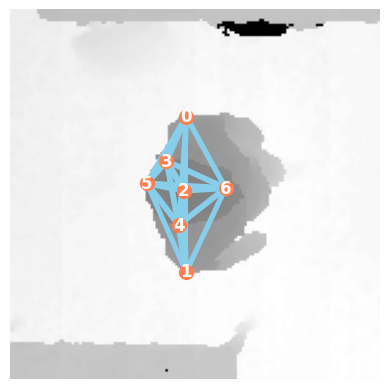

[0.848, 0.6472, 0.2556, 0.262, 0.2852, 0.3576, 0.3532]
[0.8256, 0.4888, 0.2808, 0.3532, 0.3804, 0.3632, 0.2588]
[0.8256, 0.4832, 0.26, 0.2652, 0.3776, 0.3648, 0.2624]
[0.8244, 0.49, 0.272, 0.3532, 0.378, 0.3616, 0.2568]
[0.8148, 0.4776, 0.3532, 0.3492, 0.3764, 0.366, 0.2624]
[0.8596, 0.678, 0.2528, 0.2684, 0.29, 0.3572, 0.3532]
[0.88, 0.8596, 0.2556, 0.272, 0.2772, 0.362, 0.3576]
[0.8712, 0.8524, 0.2544, 0.2768, 0.2704, 0.3548, 0.35]
[0.8712, 0.8584, 0.2556, 0.276, 0.2608, 0.3532, 0.3532]
[0.8832, 0.8596, 0.2528, 0.2752, 0.2724, 0.3532, 0.3704]
[0.8148, 0.4744, 0.3452, 0.598, 0.3704, 0.8256, 0.2744]
[0.8368, 0.5148, 0.2496, 0.3492, 0.2932, 0.3548, 0.2564]
[0.8712, 0.8596, 0.2556, 0.2752, 0.2788, 0.3616, 0.3616]
[0.8596, 0.7868, 0.2556, 0.2732, 0.2932, 0.3576, 0.3552]
[0.8596, 0.8276, 0.2528, 0.266, 0.2856, 0.3552, 0.3576]
[0.8712, 0.8596, 0.2556, 0.2748, 0.2644, 0.3612, 0.3492]
[0.8712, 0.8596, 0.2552, 0.2752, 0.2752, 0.3532, 0.3532]
[0.8372, 0.4908, 0.2652, 0.3508, 0.296, 0.3588, 0.26

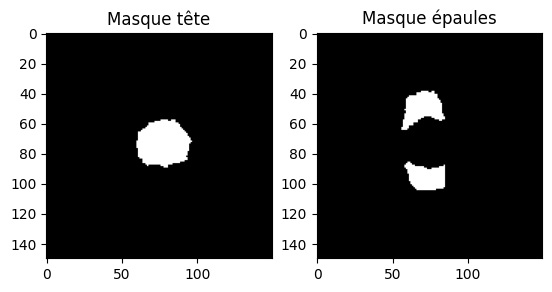

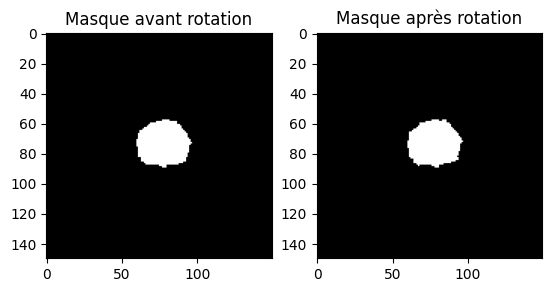

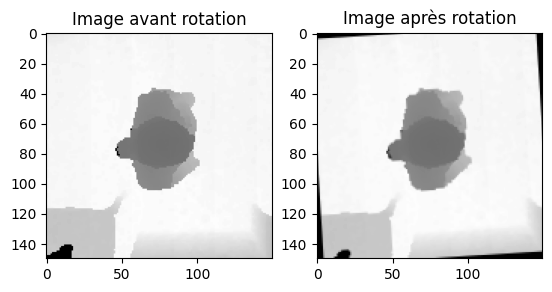

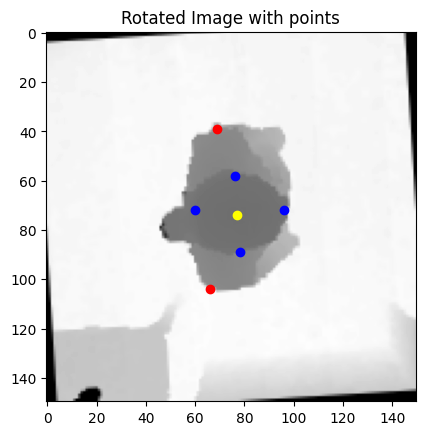

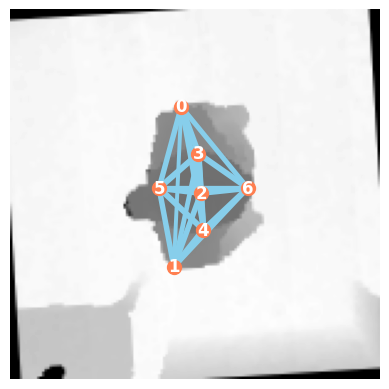

[0.3576, 0.8148, 0.2012, 0.2228, 0.1856, 0.1984, 0.8596]
[0.3412, 0.8368, 0.1956, 0.2136, 0.1952, 0.8148, 0.8712]
[0.8744, 0.86, 0.1684, 0.1832, 0.1844, 0.2824, 0.2816]
[0.8596, 0.526, 0.1684, 0.188, 0.178, 0.1912, 0.282]
[0.872, 0.848, 0.1688, 0.23, 0.1708, 0.192, 0.282]
[0.858, 0.4072, 0.1732, 0.1944, 0.1888, 0.2524, 0.2888]
[0.8832, 0.8596, 0.166, 0.1936, 0.1748, 0.1888, 0.2844]
[0.8596, 0.4512, 0.1708, 0.1888, 0.1904, 0.198, 0.2908]
[0.1744, 0.3996, 0.2872, 0.8224, 0.3368, 0.848, 0.1816]
[0.8648, 0.5656, 0.1684, 0.2132, 0.1764, 0.1892, 0.2888]
[0.3316, 0.804, 0.1868, 0.2088, 0.1856, 0.1932, 0.848]
[0.3416, 0.822, 0.1984, 0.2144, 0.1956, 0.2028, 0.8712]
[0.8832, 0.854, 0.166, 0.1908, 0.1836, 0.196, 0.3008]
[0.8832, 0.8596, 0.166, 0.1864, 0.1816, 0.1928, 0.2804]
[0.8832, 0.8596, 0.1692, 0.1968, 0.1792, 0.192, 0.2836]
[0.352, 0.848, 0.1908, 0.2092, 0.1908, 0.8, 0.8712]
[0.8596, 0.8596, 0.166, 0.1916, 0.1732, 0.1964, 0.2788]
[0.8832, 0.8596, 0.1708, 0.188, 0.1732, 0.1968, 0.282]
[0.836

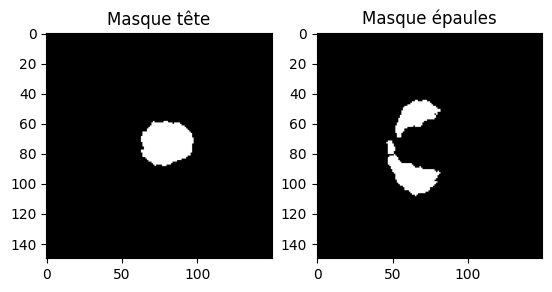

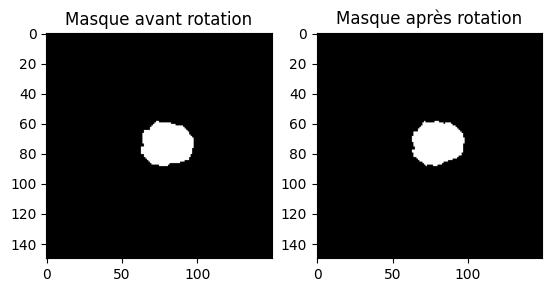

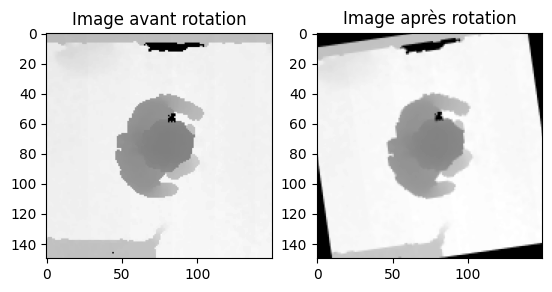

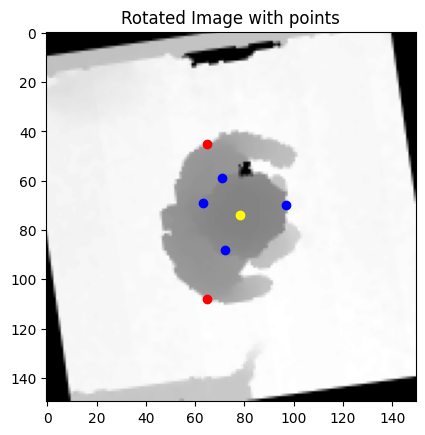

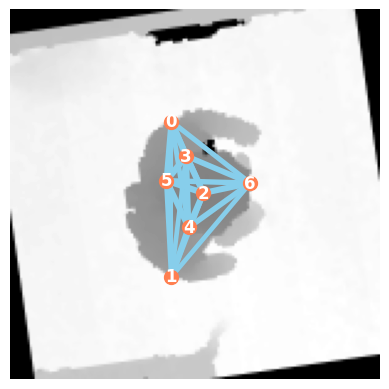

[0.8208, 0.5028, 0.2552, 0.2536, 0.2852, 0.348, -0.4]
[0.8788, 0.8596, 0.262, -0.4, 0.2664, 0.2808, 0.3724]
[0.8712, 0.8772, 0.2652, 0.3104, 0.2752, 0.2924, 0.3672]
[0.8712, 0.8624, 0.272, 0.318, 0.2752, 0.2888, 0.3836]
[0.8832, 0.8596, 0.2568, 0.2648, 0.2684, 0.2952, 0.3824]
[0.8712, 0.8596, 0.2784, 0.3228, 0.272, 0.2784, 0.3652]
[0.8596, 0.8712, 0.2644, 0.3212, 0.2744, 0.2812, 0.366]
[0.842, 0.5216, 0.2684, 0.2564, 0.4064, 0.2992, 0.2872]
[0.8832, 0.848, 0.2588, -0.4, 0.2656, 0.3056, 0.376]
[0.8832, 0.8596, 0.8832, 0.8712, 0.2652, 0.2752, 0.384]
[0.8832, 0.8596, 0.2556, 0.3184, 0.268, 0.282, 0.366]
[0.8368, 0.5736, 0.262, 0.122, 0.3392, 0.3092, 0.2992]
[0.882, 0.8596, 0.2588, 0.3072, 0.2684, 0.2856, 0.3704]
[0.8832, 0.8596, 0.272, 0.3256, 0.2752, 0.2908, 0.3788]
[0.8256, 0.48, 0.268, 0.2464, 0.2776, 0.3532, 0.2784]
[0.8368, 0.5792, 0.262, 0.282, 0.3388, 0.3596, 0.3064]
[0.846, 0.594, 0.2684, 0.2768, 0.4112, 0.3176, 0.2972]
[0.846, 0.574, 0.262, 0.0384, 0.2904, 0.2988, 0.3588]
[0.8832

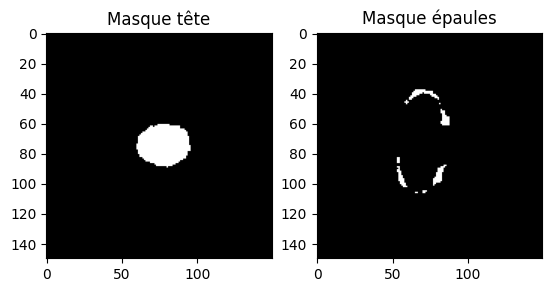

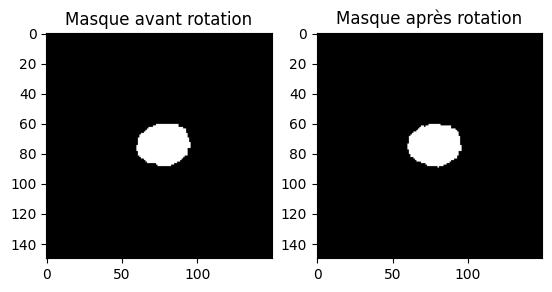

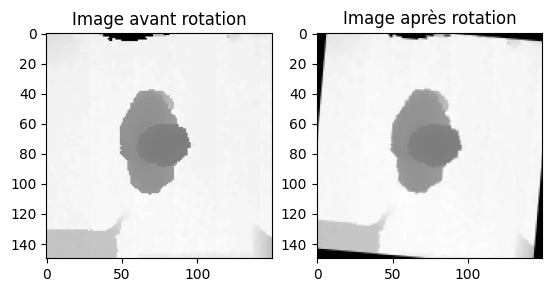

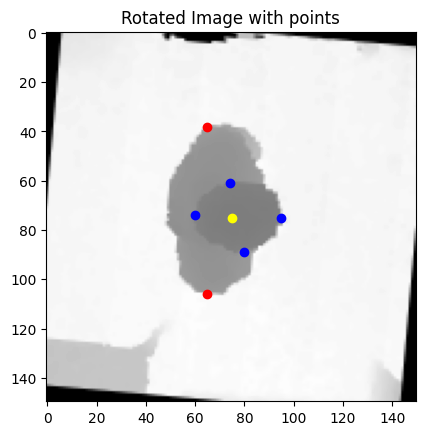

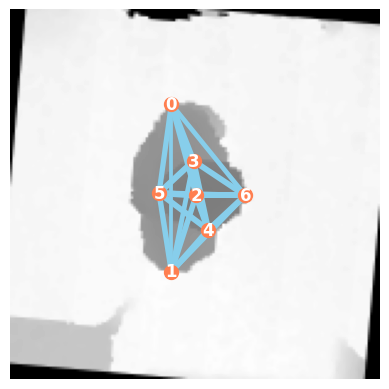

[0.8832, 0.8596, 0.2404, 0.2676, 0.2516, 0.3684, 0.358]
[0.8408, 0.5128, 0.2532, 0.2428, 0.2636, 0.3524, 0.3412]
[0.848, 0.8832, 0.256, 0.2628, 0.2724, 0.3628, 0.3488]
[0.8832, 0.8596, 0.2404, 0.326, 0.2476, 0.3412, 0.3576]
[0.8368, 0.8832, 0.262, 0.2564, 0.2628, 0.3536, 0.3528]
[0.8368, 0.8712, 0.2528, 0.3744, 0.2684, 0.3576, 0.3492]
[0.8832, 0.8596, 0.2404, 0.2684, 0.2464, 0.336, 0.36]
[0.8832, 0.8596, 0.2404, 0.268, 0.2464, 0.3036, 0.3532]
[0.8832, 0.8596, 0.2404, 0.2684, 0.2464, 0.352, 0.3532]
[0.8596, 0.8832, 0.246, 0.26, 0.2524, 0.344, 0.3704]
[0.8712, 0.8672, 0.2508, 0.2608, 0.2528, 0.342, 0.364]
[0.8832, 0.8568, 0.2404, 0.2652, 0.244, 0.3408, 0.3676]
[0.8712, 0.8596, 0.2464, 0.2652, 0.252, 0.338, 0.366]
[0.8188, 0.462, 0.2396, 0.2408, 0.2996, 0.3372, 0.3032]
[0.804, 0.4772, 0.2888, 0.2376, 0.3644, 0.3388, 0.2516]
[0.8712, 0.8596, 0.2436, 0.26, 0.2476, 0.3504, 0.3656]
[0.8308, 0.8812, 0.2548, 0.2576, 0.2744, 0.3576, 0.3452]
[0.8832, 0.8596, 0.2404, 0.2664, 0.2496, 0.3632, 0.3656

In [ ]:
graph_dict = {}

for id_fold, subfold in enumerate(sorted(os.listdir(fold_images))):
    # Construct the path to the current subfolder
    subfold_path = os.path.join(fold_images, subfold)

    # Initialize a counter variable
    i = 0

    # Create an empty list to store graphs
    graph_list = []

    # Iterate through the files in the subfolder
    for filename in os.listdir(subfold_path):
        # Construct the full path to the depth image file
        image_path_depth = os.path.join(subfold_path, filename)

        # Check if the file is a depth image (based on the filename)
        if filename.endswith("_D.png"):
            # Read the depth image
            depth_image = cv2.imread(image_path_depth, cv2.IMREAD_UNCHANGED)

            # Find masks for head and shoulders, and calculate rotation angle
            sommet_head, mask_head, mask_shoulders = find_masks(depth_image, 10, 24, 36)
            angle = find_angle(mask_shoulders)

            # Rotate masks and depth image based on the calculated angle
            rotated_mask_shoulders = rotate_mask_by_angle(mask_shoulders, angle)
            rotated_mask_head = rotate_mask_by_angle(mask_head, angle)
            rotated_depth_image = rotate_image_by_angle(depth_image, angle)

            # Find extreme points for shoulders and head masks
            top_shoulders, bottom_shoulders, left_shoulders, right_shoulders = find_extreme_points(rotated_mask_shoulders)
            top_head, bottom_head, left_head, right_head = find_extreme_points(rotated_mask_head)

            # Create a list of points for the graph
            points_list = [top_shoulders, bottom_shoulders, sommet_head, top_head, bottom_head, left_head, right_head]

            # Calculate distance matrix and depth values for the points
            matrix_distance = distance_matrix(points_list)
            list_depth_values = get_list_depth_values(rotated_depth_image, points_list)

            # Create a graph from the points with associated depth values
            graph = create_graph_from_points_with_depth(matrix_distance, points_list, list_depth_values)

            # Append the graph to the list
            graph_list.append(graph)
            # print(list_depth_values)

            final_display_from_id(i, 1)
            # Increment the counter
            i += 1

    # Store the list of graphs for the current subfolder
    graph_dict[subfold_path] = graph_list

# Partie GCN

In [ ]:
for graph in graph_dict['fold_images/VID_001_ID_0001']:
    for node, data in graph.nodes(data=True):
        print(f"Node {node} with attributes: {data}")
    for edge in graph.edges(data=True):
      node1, node2, data = edge
      weight = data['weight']
      print(f"Edge ({node1}, {node2}) has weight: {weight}")

In [ ]:
# !pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-${TORCH}+${CUDA}.html
# !pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-${TORCH}+${CUDA}.html
# !pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-${TORCH}+${CUDA}.html
# !pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-${TORCH}+${CUDA}.html
!pip install torch-geometric

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch_geometric.loader import DataLoader

In [ ]:
labels_list = [1, 2, 3, 4, 4, 2, 3, 1]
pytorch_data_dict = {}

# Suppose you have a function to create a PyTorch Geometric Data object from your NetworkX graph
def graph_to_pytorch_data(graph):
    edge_index = torch.tensor(list(graph.edges)).t().contiguous()
    x = torch.tensor([graph.nodes[i]['depth'] for i in graph.nodes], dtype=torch.float).view(-1, 1)
    edge_weights = torch.tensor([graph.edges[edge]['weight'] for edge in graph.edges], dtype=torch.float).view(1, -1)
    return Data(x=x, edge_index=edge_index, edge_attr=edge_weights)

for index, (video_name, graph_list) in enumerate(graph_dict.items()):
    pytorch_data_list = [graph_to_pytorch_data(graph) for graph in graph_list]
    # Associer l'étiquette à chaque objet Data
    label = labels_list[index]
    for data in pytorch_data_list:
        data.y = torch.tensor([label], dtype=torch.long)
    pytorch_data_dict[video_name] = pytorch_data_list

In [ ]:
# Define a simple GCN model
class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Instantiate the GCN model
model = GCN(input_dim=1, hidden_dim=16, output_dim=1)

In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()

    for data in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data.y)  # Supposons que data.y contient les étiquettes de classe
        loss.backward()
        optimizer.step()

    # Évaluation sur l'ensemble de validation
    model.eval()
    with torch.no_grad():
        total_correct = 0
        total_samples = 0

        for data in validation_loader:
            output = model(data)
            _, predicted = torch.max(output, 1)
            total_correct += (predicted == data.y).sum().item()
            total_samples += data.y.size(0)

        accuracy = total_correct / total_samples
        print(f'Epoch {epoch + 1}/{num_epochs}, Validation Accuracy: {accuracy:.4f}')


In [ ]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
for epoch in range(100):
    total_loss = 0
    for data in pytorch_data_list:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data.x)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    average_loss = total_loss / len(pytorch_data_list)
    print(f'Epoch {epoch+1}/{100}, Average Loss: {average_loss}')

In [ ]:
# After training, you can use the model to make predictions
with torch.no_grad():
    predicted_depths = [model(data).detach().numpy() for data in pytorch_data_list]
    print("Predicted Depths:", predicted_depths)

Predicted Depths: [array([[1576.5763],
       [2072.342 ],
       [2303.761 ],
       [2449.3765],
       [2548.2131],
       [2621.146 ],
       [2680.0835]], dtype=float32), array([[1564.615 ],
       [2055.9172],
       [2285.9028],
       [2431.334 ],
       [2530.6897],
       [2605.2168],
       [2665.2874]], dtype=float32), array([[1581.56  ],
       [2077.6282],
       [2308.8147],
       [2454.2324],
       [2553.0386],
       [2625.7659],
       [2684.2258]], dtype=float32), array([[1528.7311],
       [1928.1469],
       [2125.3428],
       [2254.886 ],
       [2346.1099],
       [2417.8296],
       [2476.3018]], dtype=float32), array([[1591.0295],
       [2090.0393],
       [2321.6716],
       [2461.4978],
       [2557.0876],
       [2631.7793],
       [2691.9983]], dtype=float32), array([[ 972.53  ],
       [1420.69  ],
       [1648.9185],
       [1799.721 ],
       [1908.3978],
       [2013.1403],
       [2110.847 ]], dtype=float32), array([[1591.0295],
       [2083.934 ],